# Lever centered firing rate maps

We wondered whether some neurons could encode the proximity to lever or consistently fire near the lever. These neurons would have a nicer firing rate map when the position data is centered on the lever position.


In [1]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:37<00:00,  1.05it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [2]:
%%time
myProjectWithTrials = loadMyProjectWithTrials(myProject)
prepareSessionsForSpatialAnalysisProject(sSesList,myProjectWithTrials.sessionList,pose_file_extension = ".pose_kf.npy")

Loading: /adata/projects/autopi_ca1/results/myProjectWithTrials.pickle
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:20<00:00,  1.88it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict
CPU times: user 16.5 s, sys: 6.44 s, total: 23 s
Wall time: 45.4 s


In [3]:
for ses, sSes in tqdm(zip(myProject.sessionList,sSesList)):
    getSearchHomingIntervals(ses,sSes)
ses.intervalDict.keys()

39it [00:00, 64.48it/s]


dict_keys(['circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_1', 'light_2', 'dark', 'dark_1', 'dark_2', 'searchPath_light', 'searchPath_light_1', 'searchPath_light_2', 'searchPath_dark', 'searchPath_dark_1', 'searchPath_dark_2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingPath_light', 'homingPath_light_1', 'homingPath_light_2', 'homingPath_dark', 'homingPath_dark_1', 'homingPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_light_1', 'homingFromLeavingLeverToPeriphery_light_2', 'homingFromLeavingLeverToPeriphery_dark', 'homingFromLeavingLeverToPeriphery_dark_1', 'homingFromLeavingLeverToPeriphery_

## Firing as a function of distance to lever

We need to get the more precise distance from the lever box.

In [4]:
ses = myProjectWithTrials.sessionList[0]
sSes = sSesList[0]

In [5]:
res = ses.getDistanceFromLever()

no bridge time; no adjustTrialStart
mn5824-20112020-0107_1, no mouse position data during this trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, the mouse was detected for fewer than 20 frames during the trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, no lever position data during this trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_51, start time adjustment: -18.4626 sec
{}, start time adjustment would be too large, something is wrong.
keep original start time


In [6]:
def trialDistanceFromLever2PoseShape(sSes,res):
    """
    Get the distance from Lever in a format that fits the sSes.ap.pose
    
    Arguments:
    sSes: spikeA session
    res: output of autopipy.session.getDistanceFromLever()
    
    """
    
    dDf = pd.DataFrame({"resTime":sSes.ap.pose[:,0]})
    d1Df = pd.DataFrame({"resTime":res[:,0],
                   "distance":res[:,1]})
    df = pd.merge(dDf,d1Df,on="resTime",how="left")
    return d.distance.to_numpy()

In [7]:
d = trialDistanceFromLever2PoseShape(sSes,res)

NameError: name 'd' is not defined

In [ ]:
d

In [ ]:
plt.hist(d,bins=100)
plt.show()

In [90]:
from os.path import exists

def getDistanceRateHisto(ses,sSes,interName="dark",maxDistance=30, iterations=100,percentile=0.95):
    """
    Get all the lever-centered histograms of the data within the intervals of interest
    
    The occupancy histograms is also returned
    
    It also gives you the peak firing rate in the histogram that you would expect to get by chance, if spikes are moved in time on the path. 
    
    """
   
    # change the x and y position of the mouse so that it is relative to the lever position
    #print(ses.name)
    
    sSes.ap.load_pose_from_file() # get original hd data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    
    D = distanceToLeverBox(ses,sSes,maxDistance=30)
    mouseX= D
    
    # replace x by mouseX in ap.pose_ori[:1]
    sSes.ap.pose_ori[:,1] = mouseX
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_histogram(cm_per_bin =1, smoothing_sigma_cm = 1, smoothing=True,x_range = np.array([0,maxDistance]) )
        
    mapStack = np.vstack([ n.spatial_properties.firing_rate_histo for n in sSes.cg.neuron_list ])
    occStack = np.vstack([ n.spatial_properties.ap.occupancy_histo for n in sSes.cg.neuron_list ])
    

    def runShufflePeakRate(n):
        """
        Function to implement the shuffle procedure to get chance levels for the peak rates 
        
        The shuffle will include all time periods of the interName type (e.g., dark). This means that periods away from the lever gets into the histograms.
        The focus on 0,30 is when making the histogram. 
        """
        # allocate memory for the shuffle data
        peaks_shuffle=np.empty(iterations)
        for i in range(iterations):
            sSes.ap.roll_pose_over_time() # shuffle the position data on each iteration by a random amount
            n.spatial_properties.firing_rate_histogram(cm_per_bin =1, smoothing_sigma_cm = 1, smoothing=True,x_range = np.array([0,maxDistance])) 
            peaks_shuffle[i] =  np.nanmax(n.spatial_properties.firing_rate_histo)
            
        # calculate the threshold
        peak_threshold =  np.percentile(peaks_shuffle,percentile)
        return(peak_threshold)
        
        
    # do the shuffle to get the chance lever for the peak firing rate
    peakThresholds = np.array([runShufflePeakRate(n) for n in sSes.cg.neuron_list])
    
    
    sSes.ap.load_pose_from_file() # get original position data
    
    return mapStack,occStack,peakThresholds


def distanceToLeverBox(ses,sSes,maxDistance=30):
    """
    Get the distance fo the animal from the lever box, set value above maxDistance to np.nan
    
    Get the walls of the lever box to get distance
    """

    fn = sSes.path+"/leverBoxDistance.npy"
    
    if exists(fn):
        #print(fn,"exists")
        D = np.load(fn)
    else:
        print(fn,"does not exist, generating data")
        res = ses.getDistanceFromLever()
        dDf = pd.DataFrame({"resTime":sSes.ap.pose[:,0]})
        d1Df = pd.DataFrame({"resTime":res[:,0],
                       "distance":res[:,1]})
        df = pd.merge(dDf,d1Df,on="resTime",how="left")
        D =  df.distance.to_numpy()
        print("saving",fn)
        np.save(fn,D)
    
    D[D>maxDistance] = np.nan
    return D


def distanceToLeverCenter(ses,sSes,maxDistance=30):
    """
    Get distance of the animal from the lever center, set value above maxDistance to np.nan
    
    Use lever center to get distance.
    
    We don't use this function anymore as there is a way to get the distance from the lever box (closest wall of the lever box)
    
    """
    # calculate lever position
    fn = sSes.path+"/leverPose"
    leverPose = pd.read_csv(fn)
    leverX = (leverPose.leverPressX + leverPose.leverBoxPLX + leverPose.leverBoxPRX)/3
    leverY = (leverPose.leverPressY + leverPose.leverBoxPLY + leverPose.leverBoxPRY)/3
    
    # transform the animal position so that it is centered on lever
    mouseX = sSes.ap.pose[:,1]-leverX
    mouseY = sSes.ap.pose[:,2]-leverY
    
    # distance to lever
    D = np.sqrt(mouseX**2+mouseY**2)  
    
    D[D>maxDistance] = np.nan
    
    return D

In [91]:
#[ (i,ses.name) for i,ses in enumerate(sSesList)]
sSes = sSesList[0]
ses = myProjectWithTrials.sessionList[0]

In [92]:
maps, occ, peakThresholds = getDistanceRateHisto(ses,sSes)

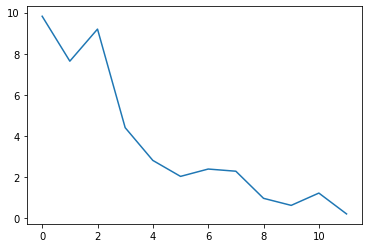

In [93]:
plt.plot(peakThresholds)

(0.0, 46.98411051217147)

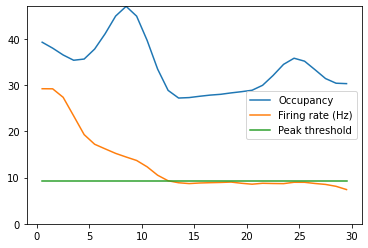

In [94]:
neuronIndex=2
mids = sSes.cg.neuron_list[neuronIndex].spatial_properties.firing_rate_histo_mid
plt.plot(mids,occ[neuronIndex,:],label="Occupancy")
plt.plot(mids,maps[neuronIndex,:],label="Firing rate (Hz)")
plt.plot([np.min(mids),np.max(mids)],[peakThresholds[neuronIndex],peakThresholds[neuronIndex]],label="Peak threshold")
plt.legend()
myMax = np.nanmax(np.concatenate([occ[neuronIndex,:],maps[neuronIndex,:]]))
plt.ylim(0,myMax)

In [95]:
res1 = maps/np.expand_dims(np.nanmax(maps,axis=1),axis=1)

(12, 30)


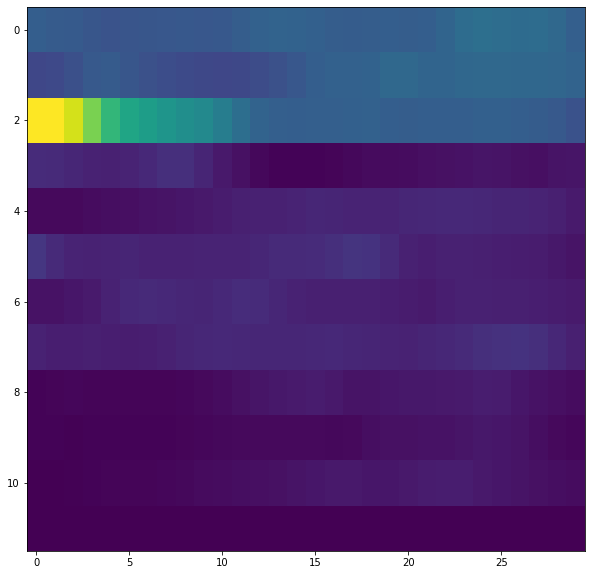

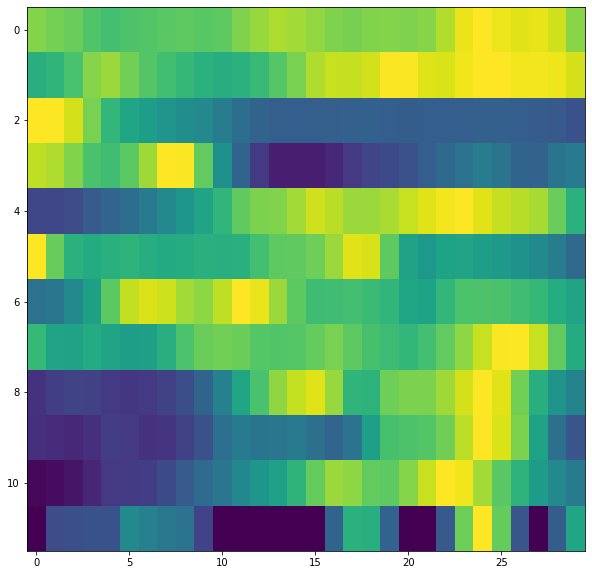

In [96]:
plt.figure(figsize=(10,10))
print(maps.shape)
plt.imshow(maps,interpolation=None,aspect="auto")
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(res1,interpolation=None,aspect="auto")

In [97]:
ses.intervalDict.keys()

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_1', 'light_2', 'dark', 'dark_1', 'dark_2', 'searchPath_light', 'searchPath_light_1', 'searchPath_light_2', 'searchPath_dark', 'searchPath_dark_1', 'searchPath_dark_2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingPath_light', 'homingPath_light_1', 'homingPath_light_2', 'homingPath_dark', 'homingPath_dark_1', 'homingPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_light_1', 'homingFromLeavingLeverToPeriphery_light_2', 'homingFromLeavingLeverToPeriphery_dark', 'homingFromLeavingLeverToPeriphery_dark_1', 'homingFromLeavingLeverToPeriphery_

In [98]:
conditions = ["light","dark","all_light","all_dark"]
keys = conditions

In [99]:
%%time
myLeverHistos = {}
for key,cond in zip(keys,conditions):
    print(key)
    myLeverHistos[key] = ([getDistanceRateHisto(ses,sSes,cond) for ses,sSes in tqdm(zip(myProjectWithTrials.sessionList,sSesList))])

light



0it [00:00, ?it/s]
1it [00:06,  6.40s/it]
2it [00:18,  9.96s/it]
3it [00:23,  7.58s/it]
4it [00:28,  6.70s/it]
5it [00:37,  7.33s/it]
6it [00:41,  6.26s/it]
7it [01:11, 14.14s/it]
8it [01:44, 20.08s/it]
9it [02:19, 24.70s/it]
10it [02:47, 25.63s/it]
11it [03:15, 26.44s/it]
12it [03:19, 19.67s/it]
13it [03:25, 15.40s/it]
14it [03:33, 13.32s/it]
15it [03:42, 12.05s/it]
16it [03:47,  9.76s/it]
17it [04:02, 11.31s/it]
18it [04:25, 14.86s/it]
19it [04:36, 13.73s/it]
20it [04:48, 13.20s/it]
21it [05:13, 16.69s/it]
22it [05:51, 23.09s/it]
23it [06:34, 29.24s/it]
24it [07:01, 28.34s/it]
25it [07:11, 22.82s/it]
26it [07:19, 18.35s/it]
27it [07:46, 20.94s/it]
28it [07:50, 15.99s/it]
29it [08:14, 18.46s/it]
30it [08:45, 22.19s/it]
31it [09:14, 24.26s/it]
32it [09:42, 25.45s/it]
33it [09:57, 22.26s/it]
34it [10:06, 18.26s/it]
35it [10:19, 16.63s/it]
36it [10:40, 18.10s/it]
37it [11:13, 22.33s/it]
38it [11:50, 26.93s/it]
39it [12:21, 19.00s/it]


dark



0it [00:00, ?it/s]
1it [00:10, 10.83s/it]
2it [00:34, 18.38s/it]
3it [00:42, 13.61s/it]
4it [00:51, 11.63s/it]
5it [00:57,  9.87s/it]
6it [01:01,  7.69s/it]
7it [01:22, 12.10s/it]
8it [01:56, 19.14s/it]
9it [02:30, 23.66s/it]
10it [03:00, 25.68s/it]
11it [03:38, 29.60s/it]
12it [03:44, 22.32s/it]
13it [03:53, 18.36s/it]
14it [04:09, 17.69s/it]
15it [04:23, 16.51s/it]
16it [04:30, 13.69s/it]
17it [04:52, 15.96s/it]
18it [05:23, 20.49s/it]
19it [05:37, 18.56s/it]
20it [05:48, 16.32s/it]
21it [06:33, 24.89s/it]
22it [07:52, 41.17s/it]
23it [09:06, 51.17s/it]
24it [10:03, 52.75s/it]
25it [10:20, 41.99s/it]
26it [10:31, 32.71s/it]
27it [11:07, 33.74s/it]
28it [11:16, 26.50s/it]
29it [11:55, 30.22s/it]
30it [13:25, 48.06s/it]
31it [14:00, 44.12s/it]
32it [14:35, 41.40s/it]
33it [14:56, 35.41s/it]
34it [15:11, 29.08s/it]
35it [15:33, 27.10s/it]
36it [16:05, 28.61s/it]
37it [17:02, 37.02s/it]
38it [17:49, 40.01s/it]
39it [18:33, 28.55s/it]


all_light



0it [00:00, ?it/s]
1it [00:02,  2.92s/it]
2it [00:08,  4.33s/it]
3it [00:10,  3.36s/it]
4it [00:13,  3.13s/it]
5it [00:15,  2.69s/it]
6it [00:16,  2.11s/it]
7it [00:20,  2.89s/it]
8it [00:26,  3.87s/it]
9it [00:33,  4.87s/it]
10it [00:39,  5.02s/it]
11it [00:43,  4.97s/it]
12it [00:46,  4.23s/it]
13it [00:49,  3.89s/it]
14it [00:54,  4.27s/it]
15it [00:59,  4.40s/it]
16it [01:02,  3.95s/it]
17it [01:07,  4.24s/it]
18it [01:15,  5.42s/it]
19it [01:19,  5.19s/it]
20it [01:22,  4.52s/it]
21it [01:32,  6.13s/it]
22it [01:50,  9.60s/it]
23it [02:04, 10.87s/it]
24it [02:14, 10.63s/it]
25it [02:18,  8.74s/it]
26it [02:23,  7.60s/it]
27it [02:35,  8.90s/it]
28it [02:37,  6.91s/it]
29it [02:50,  8.74s/it]
30it [03:04, 10.11s/it]
31it [03:12,  9.54s/it]
32it [03:19,  8.86s/it]
33it [03:25,  7.85s/it]
34it [03:28,  6.61s/it]
35it [03:33,  6.01s/it]
36it [03:42,  6.78s/it]
37it [03:56,  8.93s/it]
38it [04:09, 10.26s/it]
39it [04:21,  6.71s/it]


all_dark



0it [00:00, ?it/s]
1it [00:03,  3.79s/it]
2it [00:11,  6.13s/it]
3it [00:14,  4.78s/it]
4it [00:18,  4.55s/it]
5it [00:23,  4.38s/it]
6it [00:24,  3.36s/it]
7it [00:30,  4.25s/it]
8it [00:37,  5.27s/it]
9it [00:46,  6.27s/it]
10it [00:52,  6.15s/it]
11it [00:57,  6.01s/it]
12it [01:01,  5.24s/it]
13it [01:06,  5.10s/it]
14it [01:14,  6.07s/it]
15it [01:21,  6.47s/it]
16it [01:25,  5.73s/it]
17it [01:32,  6.08s/it]
18it [01:46,  8.27s/it]
19it [01:52,  7.80s/it]
20it [01:57,  6.86s/it]
21it [02:11,  9.10s/it]
22it [02:38, 14.29s/it]
23it [03:04, 17.92s/it]
24it [03:23, 18.28s/it]
25it [03:31, 15.06s/it]
26it [03:33, 11.29s/it]
27it [03:44, 11.00s/it]
28it [03:48,  8.91s/it]
29it [04:04, 11.13s/it]
30it [04:30, 15.47s/it]
31it [04:42, 14.60s/it]
32it [04:53, 13.59s/it]
33it [05:01, 11.90s/it]
34it [05:07,  9.92s/it]
35it [05:13,  8.99s/it]
36it [05:25,  9.88s/it]
37it [05:45, 12.86s/it]
38it [06:04, 14.48s/it]
39it [06:19,  9.74s/it]

CPU times: user 41min 6s, sys: 9.82 s, total: 41min 16s
Wall time: 41min 36s


The data in a dictionary with the different conditions. Within a condition, there is a list of tuples (histos,occups,peakThresholds)

dict_keys(['light', 'dark', 'all_light', 'all_dark'])
(12, 30)
(12, 30)
(12,)


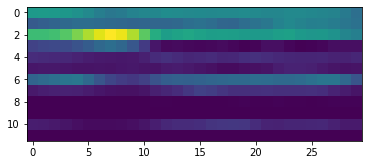

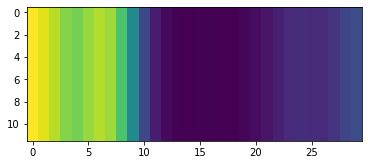

In [100]:
print(myLeverHistos.keys())
oneSesData = myLeverHistos["light"][0]
print(oneSesData[0].shape)
print(oneSesData[1].shape)
print(oneSesData[2].shape)
plt.imshow(oneSesData[0])
plt.show()
plt.imshow(oneSesData[1])
plt.show()


In [101]:
histos={}
occups={}
peakThresholds={}
for k in myLeverHistos.keys():
    histos[k] = np.concatenate([e[0] for e in myLeverHistos[k]])
    occups[k] = np.concatenate([e[1] for e in myLeverHistos[k]])
    peakThresholds[k] = np.concatenate([e[2] for e in myLeverHistos[k]])
print(histos["light"].shape,occups["light"].shape, peakThresholds["light"].shape)

(1268, 30) (1268, 30) (1268,)


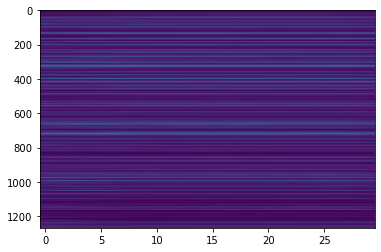

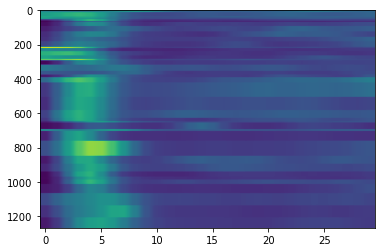

In [102]:
plt.imshow(histos["dark"],aspect="auto",interpolation=None)
plt.show()
plt.imshow(occups["dark"],aspect="auto",interpolation=None)

In [103]:
sSes.cg.neuron_list[0].spatial_properties.firing_rate_histo_mid

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5])

In [104]:
fn=myProject.dataPath+"/results/myLeverHistos.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump([histos,occups,sSes.cg.neuron_list[-1].spatial_properties.firing_rate_histo_mid,peakThresholds], handle)

saving: /adata/projects/autopi_ca1/results/myLeverHistos.pickle


## Firing rate maps around the lever

In [4]:
#[ (i,ses.name) for i,ses in enumerate(sSesList)]
sSes = sSesList[-2]
ses = myProjectWithTrials.sessionList[-2]

In [5]:
def getLeverMaps(ses,sSes,interName="light",maxDistance=30, rotationType="none",
                 invalidateSmallBridgeAngle=False,invalidateMaxAngle=np.pi/12,
                 rateType="map",stats=False):
    """
    Get all the lever-centered firing rate maps or firing rate polar plots around the lever. The data can be plotted in different reference coordinate system.
    The lever position is set to 0,0.
    The orientation is either unchanged ("none") or relative to the vector going from the lever to the bridge ("bridge") or relative to the lever orientation ("lever")
    
    Arguments
    ses: autopipy session
    sSes: spikeA session
    interName: name of intervals to use (from ses.intervalDict)
    maxDistance: max distance from lever
    rotationType: can be "none","bridge","lever", once centered on the lever,
                    we can rotate the position to have different reference frame (cartesian (none), relative to bridge direction, relative to lever orientation)
    invalidateSmallBridgeAngle: whether to invalidate lever position when the bridge angle is small (for which cartesian and brdige reference frames are the same)
                                This is done to eliminate data when the none and brdige rotations are the same
                                This can be used to better contrast the prediction of "bridge" and "none" rotation
    invalidateMaxAngle: angle below which we invalidate
    rateType: (map) firing rate maps or (angular) angular rate histogram
    stats: whether to return the statistics instead of the map.
    
    """
   
    # change the x and y position of the mouse so that it is relative to the lever position
    #print(ses.name)
    
    sSes.ap.load_pose_from_file() # get original hd data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    
    # transform the coordinate system of the position data, in setup_project.py
    toLeverReferenceFrame(ses=ses,sSes=sSes,maxDistance=maxDistance, rotationType=rotationType,
                         invalidateSmallBridgeAngle=invalidateSmallBridgeAngle,invalidateMaxAngle=invalidateMaxAngle)

    sSes.ap.set_intervals(ses.intervalDict[interName])

    if rateType=="map": # normal 2D maps
        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(ses.intervalDict[interName])
            n.spatial_properties.firing_rate_map_2d(cm_per_bin =1, smoothing_sigma_cm = 2, smoothing=True,xy_range = np.array([[-maxDistance,-maxDistance],[maxDistance,maxDistance]]) )
        mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
        mapStack = np.stack(mapList, axis=0)
    elif rateType=="angular" :# angular 1D maps
        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(ses.intervalDict[interName])
            n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10, smoothing=True)
        if stats == False:
            mapList = [ n.spatial_properties.firing_rate_head_direction_histo for n in sSes.cg.neuron_list ]
            mapStack = np.stack(mapList, axis=0)
        else:
            mapList = [ np.array(n.spatial_properties.head_direction_score()) for n in sSes.cg.neuron_list ] #mean_direction_rad, mean_direction_deg, mean_vector_length, peak_angle_rad, peak_rate
            mapStack = np.stack(mapList, axis=0)
    else:
        print("rateType not supported")
    
    sSes.ap.load_pose_from_file() # get original position data
    
    return mapStack

In [6]:
rateType="map"
sSes = sSesList[-1]
ses = myProject.sessionList[-1]
resMap = {}
for rotType in ["lever","bridge","none"]:
    resMap[rotType] = getLeverMaps(ses,sSes,interName="all_light",maxDistance=15,
                      rotationType = rotType, invalidateSmallBridgeAngle=False, rateType=rateType,stats=False)

In [7]:
rateType="angular"
sSes = sSesList[-1]
ses = myProject.sessionList[-1]
resAng = {}
for rotType in ["lever","bridge","none"]:
    resAng[rotType] = getLeverMaps(ses,sSes,interName="all_light",maxDistance=15,
                      rotationType = rotType, invalidateSmallBridgeAngle=False, rateType=rateType,stats=False)
print(sSes.name,sSes.path)

mn9686-01112021-0106 /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106


In [8]:
rateType="angular"
sSes = sSesList[-1]
ses = myProject.sessionList[-1]
resAngStats = {}
for rotType in ["lever","bridge","none"]:
    resAngStats[rotType] = getLeverMaps(ses,sSes,interName="all_light",maxDistance=15,
                      rotationType = rotType, invalidateSmallBridgeAngle=False, rateType=rateType,stats=True)
print(sSes.name,sSes.path)

mn9686-01112021-0106 /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106


In [9]:
print(resMap.keys())
print(resMap["lever"].shape)
print(resAng.keys())
print(resAng["lever"].shape)
print(resAngStats.keys())
print(resAngStats["lever"].shape)

dict_keys(['lever', 'bridge', 'none'])
(62, 30, 30)
dict_keys(['lever', 'bridge', 'none'])
(62, 36)
dict_keys(['lever', 'bridge', 'none'])
(62, 5)


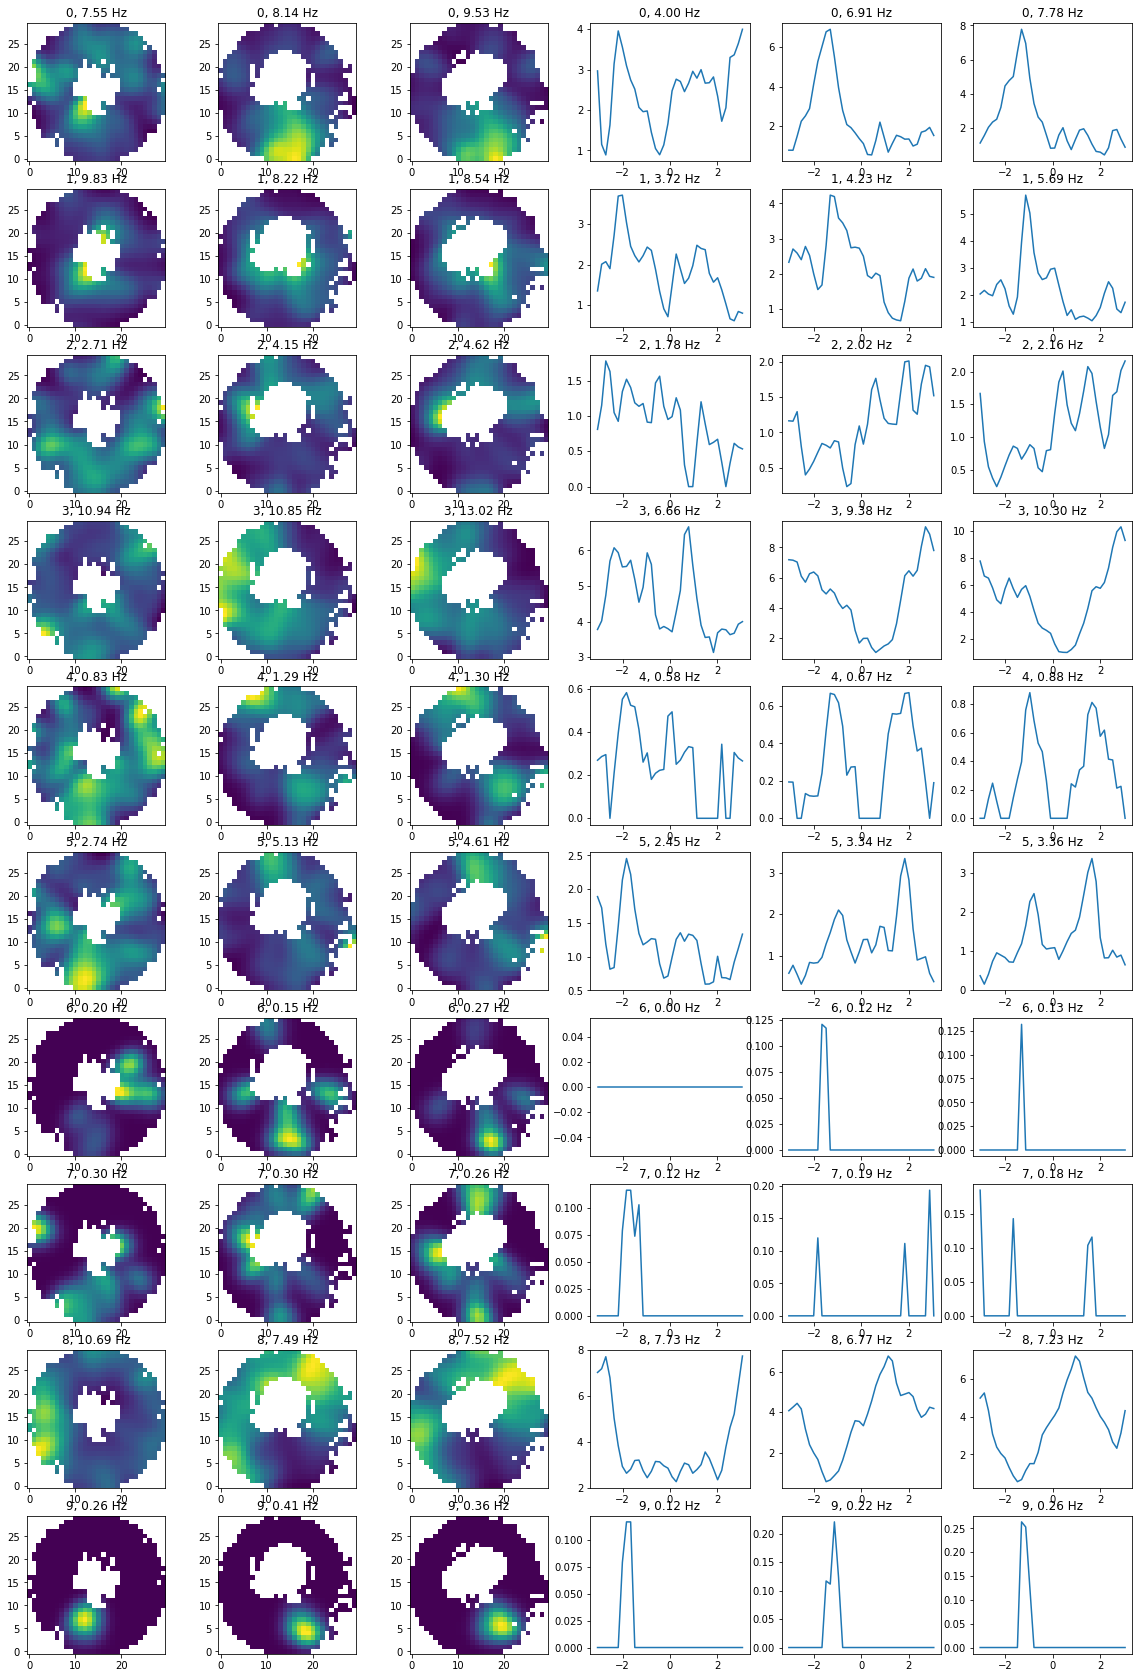

In [10]:
ncol=6
nrow=10
fig, ax = plt.subplots(nrow,ncol,figsize=(20,3*nrow))

for i in range(nrow):
    for j,rotType in enumerate(["lever","bridge","none"]):
        ax[i,j].imshow(resMap[rotType][i].T,origin="lower",interpolation=None)
        ax[i,j].set_title("{}, {:.2f} Hz".format(i,np.nanmax(resMap[rotType][i])))

for i in range(nrow):
    for j,rotType in enumerate(["lever","bridge","none"]):
        ax[i,j+3].plot(sSes.cg.neuron_list[0].spatial_properties.firing_rate_head_direction_mid_angles, resAng[rotType][i])
        ax[i,j+3].set_title("{}, {:.2f} Hz".format(i,np.nanmax(resAng[rotType][i])))
plt.show()


In [11]:
conditions = ["light","dark","all_light","all_dark","all_light_1","all_light_2","all_dark_1","all_dark_2","all_light_noPress","all_dark_noPress"]
keys = conditions

In [12]:
%%time
myLeverMaps = {}
for rateType in ["map","angular"]:
    myLeverMaps[rateType]={}
    for key,cond in zip(keys,conditions):
        myLeverMaps[rateType][key] = {}
        for rotType in ["lever","bridge","none"]:
            print(rateType,key,rotType)
            myLeverMaps[rateType][key][rotType] = np.concatenate([getLeverMaps(ses,sSes,cond,
                                                                     maxDistance=15,rotationType = rotType, 
                                                                     invalidateSmallBridgeAngle=False, rateType=rateType,
                                                                     stats=False) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))]) 

map light lever


39it [02:07,  3.26s/it]


map light bridge


39it [01:49,  2.81s/it]


map light none


39it [01:35,  2.45s/it]


map dark lever


39it [01:29,  2.30s/it]


map dark bridge


39it [01:30,  2.33s/it]


map dark none


39it [01:28,  2.28s/it]


map all_light lever


39it [01:25,  2.20s/it]


map all_light bridge


39it [01:25,  2.18s/it]


map all_light none


39it [01:23,  2.14s/it]


map all_dark lever


39it [01:18,  2.01s/it]


map all_dark bridge


39it [01:18,  2.00s/it]


map all_dark none


39it [01:17,  1.99s/it]


map all_light_1 lever


39it [00:56,  1.46s/it]


map all_light_1 bridge


39it [00:57,  1.47s/it]


map all_light_1 none


39it [00:56,  1.46s/it]


map all_light_2 lever


39it [00:57,  1.48s/it]


map all_light_2 bridge


39it [00:58,  1.49s/it]


map all_light_2 none


39it [00:57,  1.48s/it]


map all_dark_1 lever


39it [00:55,  1.43s/it]


map all_dark_1 bridge


39it [00:56,  1.44s/it]


map all_dark_1 none


39it [00:56,  1.44s/it]


map all_dark_2 lever


39it [00:56,  1.45s/it]


map all_dark_2 bridge


39it [00:56,  1.45s/it]


map all_dark_2 none


39it [00:56,  1.45s/it]


map all_light_noPress lever


39it [00:57,  1.47s/it]


map all_light_noPress bridge


39it [00:57,  1.47s/it]


map all_light_noPress none


39it [00:57,  1.46s/it]


map all_dark_noPress lever


39it [01:07,  1.74s/it]


map all_dark_noPress bridge


39it [01:07,  1.74s/it]


map all_dark_noPress none


39it [01:07,  1.73s/it]


angular light lever


39it [01:25,  2.20s/it]


angular light bridge


39it [01:26,  2.21s/it]


angular light none


39it [01:26,  2.21s/it]


angular dark lever


39it [01:22,  2.12s/it]


angular dark bridge


39it [01:22,  2.11s/it]


angular dark none


39it [01:22,  2.11s/it]


angular all_light lever


39it [01:21,  2.08s/it]


angular all_light bridge


39it [01:21,  2.09s/it]


angular all_light none


39it [01:21,  2.08s/it]


angular all_dark lever


39it [01:17,  2.00s/it]


angular all_dark bridge


39it [01:19,  2.03s/it]


angular all_dark none


39it [01:18,  2.01s/it]


angular all_light_1 lever


39it [00:56,  1.46s/it]


angular all_light_1 bridge


39it [00:58,  1.49s/it]


angular all_light_1 none


39it [00:56,  1.46s/it]


angular all_light_2 lever


39it [00:57,  1.48s/it]


angular all_light_2 bridge


39it [00:57,  1.47s/it]


angular all_light_2 none


39it [00:57,  1.47s/it]


angular all_dark_1 lever


39it [00:55,  1.42s/it]


angular all_dark_1 bridge


39it [00:56,  1.44s/it]


angular all_dark_1 none


39it [00:58,  1.50s/it]


angular all_dark_2 lever


39it [00:58,  1.50s/it]


angular all_dark_2 bridge


39it [01:07,  1.74s/it]


angular all_dark_2 none


39it [01:17,  1.98s/it]


angular all_light_noPress lever


39it [00:59,  1.52s/it]


angular all_light_noPress bridge


39it [00:57,  1.48s/it]


angular all_light_noPress none


39it [00:57,  1.47s/it]


angular all_dark_noPress lever


39it [01:07,  1.74s/it]


angular all_dark_noPress bridge


39it [01:07,  1.73s/it]


angular all_dark_noPress none


39it [01:07,  1.74s/it]

CPU times: user 1h 8min 1s, sys: 1min 36s, total: 1h 9min 38s
Wall time: 1h 10min 26s


In [13]:
print(myLeverMaps.keys())
print(myLeverMaps["map"].keys())
print(myLeverMaps["map"]["all_light"].keys())
print(myLeverMaps["map"]["all_light"]["lever"].shape)

dict_keys(['map', 'angular'])
dict_keys(['light', 'dark', 'all_light', 'all_dark', 'all_light_1', 'all_light_2', 'all_dark_1', 'all_dark_2', 'all_light_noPress', 'all_dark_noPress'])
dict_keys(['lever', 'bridge', 'none'])
(1268, 30, 30)


In [14]:
fn=myProject.dataPath+"/results/myLeverMaps.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myLeverMaps, handle)

saving: /adata/projects/autopi_ca1/results/myLeverMaps.pickle


Eliminate lever position for which the bridge angle is almost the same as south. 

In [15]:
conditions = ["all_light","all_dark","all_light_1","all_light_2","all_dark_1","all_dark_2"]
keys = conditions

In [16]:
%%time
myLeverMapsDissociate = {}
for rateType in ["map","angular"]:
    myLeverMapsDissociate[rateType]={}
    for key,cond in zip(keys,conditions):
        myLeverMapsDissociate[rateType][key] = {}
        for rotType in ["lever","bridge","none"]:
            print(rateType,key,rotType)
            myLeverMapsDissociate[rateType][key][rotType] = np.concatenate([getLeverMaps(ses,sSes,cond,
                                                                            maxDistance=15,rotationType = rotType, 
                                                                            invalidateSmallBridgeAngle=True, rateType=rateType,
                                                                            stats=False) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))])

map all_light lever


39it [01:26,  2.22s/it]


map all_light bridge


39it [01:24,  2.16s/it]


map all_light none


39it [01:23,  2.15s/it]


map all_dark lever


39it [01:21,  2.09s/it]


map all_dark bridge


39it [01:21,  2.10s/it]


map all_dark none


39it [01:21,  2.08s/it]


map all_light_1 lever


39it [00:58,  1.49s/it]


map all_light_1 bridge


39it [00:58,  1.50s/it]


map all_light_1 none


39it [00:57,  1.48s/it]


map all_light_2 lever


39it [00:59,  1.51s/it]


map all_light_2 bridge


39it [00:58,  1.51s/it]


map all_light_2 none


39it [00:58,  1.49s/it]


map all_dark_1 lever


39it [00:56,  1.45s/it]


map all_dark_1 bridge


39it [00:56,  1.45s/it]


map all_dark_1 none


39it [00:56,  1.45s/it]


map all_dark_2 lever


39it [00:57,  1.47s/it]


map all_dark_2 bridge


39it [00:57,  1.47s/it]


map all_dark_2 none


39it [00:57,  1.47s/it]


angular all_light lever


39it [01:24,  2.16s/it]


angular all_light bridge


39it [01:23,  2.14s/it]


angular all_light none


39it [01:24,  2.16s/it]


angular all_dark lever


39it [01:21,  2.09s/it]


angular all_dark bridge


39it [01:20,  2.07s/it]


angular all_dark none


39it [01:21,  2.08s/it]


angular all_light_1 lever


39it [00:57,  1.48s/it]


angular all_light_1 bridge


39it [00:57,  1.48s/it]


angular all_light_1 none


39it [00:57,  1.48s/it]


angular all_light_2 lever


39it [00:57,  1.49s/it]


angular all_light_2 bridge


39it [01:01,  1.58s/it]


angular all_light_2 none


39it [01:05,  1.69s/it]


angular all_dark_1 lever


39it [01:00,  1.55s/it]


angular all_dark_1 bridge


39it [00:58,  1.51s/it]


angular all_dark_1 none


39it [00:59,  1.53s/it]


angular all_dark_2 lever


39it [01:03,  1.62s/it]


angular all_dark_2 bridge


39it [01:07,  1.74s/it]


angular all_dark_2 none


39it [01:02,  1.59s/it]

CPU times: user 38min 8s, sys: 2min 7s, total: 40min 15s
Wall time: 40min 16s


In [17]:
fn=myProject.dataPath+"/results/myLeverMapsDissociate.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myLeverMapsDissociate, handle)

saving: /adata/projects/autopi_ca1/results/myLeverMapsDissociate.pickle


### Stats for angular histograms 
Get the stats of the angular histograms. We can use preferred phase and vector length.
We will do it for normal maps and dissociate maps.

In [15]:
conditions = ["all_light","all_dark"]
keys = conditions

In [16]:
%%time
myLeverMapsStats = {}
for rateType in ["angular"]:
    myLeverMapsStats[rateType]={}
    for key,cond in zip(keys,conditions):
        myLeverMapsStats[rateType][key] = {}
        for rotType in ["lever","bridge","none"]:
            print(rateType,key,rotType)
            myLeverMapsStats[rateType][key][rotType] = np.concatenate([getLeverMaps(ses,sSes,cond,
                                                                            maxDistance=15,rotationType = rotType, 
                                                                            invalidateSmallBridgeAngle=False, rateType=rateType,
                                                                             stats=True) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))])

angular all_light lever


39it [01:21,  2.09s/it]


angular all_light bridge


39it [01:21,  2.09s/it]


angular all_light none


39it [01:20,  2.08s/it]


angular all_dark lever


39it [01:19,  2.05s/it]


angular all_dark bridge


39it [01:18,  2.01s/it]


angular all_dark none


39it [01:17,  2.00s/it]

CPU times: user 7min 52s, sys: 8.13 s, total: 8min
Wall time: 8min


In [17]:
myLeverMapsStats["angular"]["all_light"]["none"].shape

(1268, 5)

In [18]:
fn=myProject.dataPath+"/results/myLeverMapsStats.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myLeverMapsStats, handle)

saving: /adata/projects/autopi_ca1/results/myLeverMapsStats.pickle


In [19]:
%%time
myLeverMapsDissociateStats = {}
for rateType in ["angular"]:
    myLeverMapsDissociateStats[rateType]={}
    for key,cond in zip(keys,conditions):
        myLeverMapsDissociateStats[rateType][key] = {}
        for rotType in ["lever","bridge","none"]:
            print(rateType,key,rotType)
            myLeverMapsDissociateStats[rateType][key][rotType] = np.concatenate([getLeverMaps(ses,sSes,cond,
                                                                            maxDistance=15,rotationType = rotType, 
                                                                            invalidateSmallBridgeAngle=True, rateType=rateType,
                                                                             stats=True) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))])

angular all_light lever


39it [01:21,  2.09s/it]


angular all_light bridge


39it [01:22,  2.11s/it]


angular all_light none


39it [01:21,  2.10s/it]


angular all_dark lever


39it [01:18,  2.01s/it]


angular all_dark bridge


39it [01:18,  2.02s/it]


angular all_dark none


39it [01:18,  2.01s/it]

CPU times: user 7min 52s, sys: 8.24 s, total: 8min
Wall time: 8min 1s


In [20]:
fn=myProject.dataPath+"/results/myLeverMapsDissociateStats.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myLeverMapsDissociateStats, handle)

saving: /adata/projects/autopi_ca1/results/myLeverMapsDissociateStats.pickle


## Firing rate maps around the lever, for lever positions at the North-East, North-West, South-West and South-East of the arena

In [8]:
def getLeverQuadMaps(ses,sSes,interName="light",maxDistance=30):
    """
    Get all the lever-centered maps of the data within the intervals of interest
    """
   
    # change the x and y position of the mouse so that it is relative to the lever position
    #print(ses.name)
    
    fn = sSes.path+"/leverPose"
    leverPose = pd.read_csv(fn)

    # loop for the different quadrants
    res= {}
    for quad in ["sw","nw","ne","se"]:
    
        sSes.ap.load_pose_from_file() # get original hd data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
        
        # calculate lever position
        leverX = (leverPose.leverPressX + leverPose.leverBoxPLX + leverPose.leverBoxPRX)/3
        leverY = (leverPose.leverPressY + leverPose.leverBoxPLY + leverPose.leverBoxPRY)/3

        # transform the animal position so that it is centered on lever
        mouseX = sSes.ap.pose[:,1]-leverX
        mouseY = sSes.ap.pose[:,2]-leverY
        D = np.sqrt(mouseX**2+mouseY**2)
    
        mouseX[D>maxDistance]= np.nan
        mouseY[D>maxDistance]= np.nan
        
        if quad[0] == "n": #north
            # invalidate position when lever y is below 0.
            mouseX[leverY<0]=np.nan
            mouseY[leverY<0]=np.nan
        else : # would be south
            mouseX[leverY>0]=np.nan
            mouseY[leverY>0]=np.nan
        if quad[1] == "e": #east
            mouseX[leverX<0]=np.nan
            mouseY[leverX<0]=np.nan
        else: # would be west
            mouseX[leverX>0]=np.nan
            mouseY[leverX>0]=np.nan
    
        # replace x and y by mouseX and mouseY in ap.pose_ori[:4]
        sSes.ap.pose_ori[:,1] = mouseX
        sSes.ap.pose_ori[:,2] = mouseY
    
        sSes.ap.set_intervals(ses.intervalDict[interName])
    
        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(ses.intervalDict[interName])
            n.spatial_properties.firing_rate_map_2d(cm_per_bin =1, smoothing_sigma_cm = 3, smoothing=True,xy_range = np.array([[-maxDistance,-maxDistance],[maxDistance,maxDistance]]) )
        mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
        mapStack = np.stack(mapList, axis=0)
        res[quad] = mapStack
    
    
    sSes.ap.load_pose_from_file() # get original position data
    
    
    return res

Test on one session

In [25]:
#[ (i,ses.name) for i,ses in enumerate(sSesList)]
sSes = sSesList[-1]
ses = myProject.sessionList[-1]
res = getLeverQuadMaps(ses,sSes,interName="dark")
print(sSes.name,sSes.path)

mn9686-01112021-0106 /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106


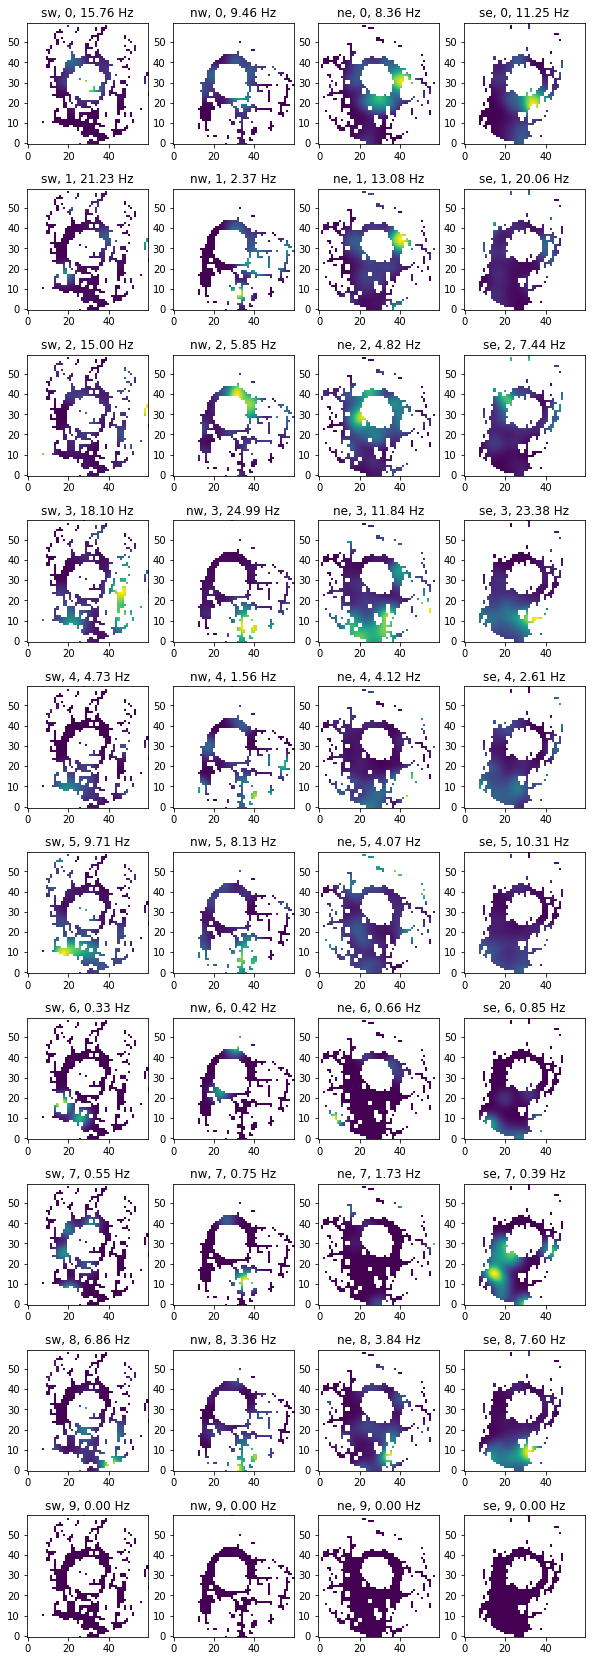

In [26]:
ncol=4
nrow=10

fig, ax = plt.subplots(nrow,ncol,figsize=(10,3*nrow))
for i in range(10):
    for j,quad in enumerate(["sw","nw","ne","se"]):
        ax[i,j].imshow(res[quad][i].T,origin="lower",interpolation=None)
        ax[i,j].set_title("{}, {}, {:.2f} Hz".format(quad,i,np.nanmax(res[quad][i])))
plt.show()

In [27]:
conditions = ["light","dark","all_light","all_dark"]
keys = conditions

In [28]:
%%time
myLeverQuadMaps = {}
for key,cond in zip(keys,conditions):
    print(key)
    myLeverQuadMaps[key] = [getLeverQuadMaps(ses,sSes,cond) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))] # we will get a list of dictionnary to reorganize later on.

light


39it [03:54,  6.01s/it]


dark


39it [03:39,  5.63s/it]


all_light


39it [03:32,  5.45s/it]


all_dark


39it [03:10,  4.89s/it]

CPU times: user 12min 52s, sys: 1min 23s, total: 14min 16s
Wall time: 14min 17s


Reformat the data so that we have stack of maps with all our neurons

In [29]:
resL1 = {} # will be a dictionary containing a dictionary 
conditions = myLeverQuadMaps.keys() 
directions = myLeverQuadMaps[cond][0].keys()
for cond in conditions:
    resL1[cond]={}
    for direction in directions:
        resL1[cond][direction] = np.concatenate([ d[direction]  for d in myLeverQuadMaps[cond]])
    

In [30]:
print(resL1.keys())
print(resL1["light"].keys())
print(resL1["light"]["sw"].shape)

dict_keys(['light', 'dark', 'all_light', 'all_dark'])
dict_keys(['sw', 'nw', 'ne', 'se'])
(1268, 60, 60)


In [31]:
fn=myProject.dataPath+"/results/myLeverQuadMaps.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(resL1, handle)

saving: /adata/projects/autopi_ca1/results/myLeverQuadMaps.pickle


## Calculate the correlation between lever-centered maps

In [9]:
from scipy.stats import pearsonr
def map_cor(a,b):
    """
    Correlation coefficient between two firing rate maps
    
    Arguments:
    a: 2D np.array (map1)
    b: 2D np.array (map2)
    
    Returns:
    Pearson correlation coefficient between a and b
    """
    a = a.flatten()
    b = b.flatten()
    indices = np.logical_and(~np.isnan(a), ~np.isnan(b))
    r,p = pearsonr(a[indices],b[indices])
    return r

We want a few types of map similarity for our figure:

* light-dark
* half of trials
* NSEW
* Press - no press


### Lever histogram correlations (no directional information)

In [10]:
fn=myProject.dataPath+"/results/myLeverHistos.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    myLeverHistos = pickle.load(handle)

loading: /adata/projects/autopi_ca1/results/myLeverHistos.pickle


In [11]:
print(myLeverHistos[0].keys())
myLeverHistos[0]["light"].shape

dict_keys(['light', 'dark', 'all_light', 'all_dark', 'all_light_noPress', 'all_dark_noPress'])


(1268, 30)

In [12]:
env1 = ['light','all_light',"all_light","all_dark"]
env2 = ['dark','all_dark',"all_light_noPress","all_dark_noPress"]
condNames = ["ld","alad","l-lnp","d-dnp"]
list(zip(env1,env2,condNames))

[('light', 'dark', 'ld'),
 ('all_light', 'all_dark', 'alad'),
 ('all_light', 'all_light_noPress', 'l-lnp'),
 ('all_dark', 'all_dark_noPress', 'd-dnp')]

In [13]:
mapCorDf = pd.DataFrame()
nCells=myLeverHistos[0]["light"].shape[0]
nCells

1268

In [14]:
for e1,e2,c in zip(env1,env2,condNames):
    print(e1,e2,c)
    correlation  = [ map_cor(myLeverHistos[0][e1][i],myLeverHistos[0][e2][i]) for i in range(nCells) ]
    df1 = pd.DataFrame({"condition":c,
                       "r":correlation})
    mapCorDf = pd.concat([mapCorDf,df1])

light dark ld
all_light all_dark alad
all_light all_light_noPress l-lnp
all_dark all_dark_noPress d-dnp


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [15]:
mapCorDf

,condition,r
0,ld,-0.124742
1,ld,0.776067
2,ld,0.525956
3,ld,0.917503
4,ld,0.318301
...,...,...
1263,d-dnp,0.903996
1264,d-dnp,0.930396
1265,d-dnp,0.695121
1266,d-dnp,-0.560251


<AxesSubplot:xlabel='condition', ylabel='r'>

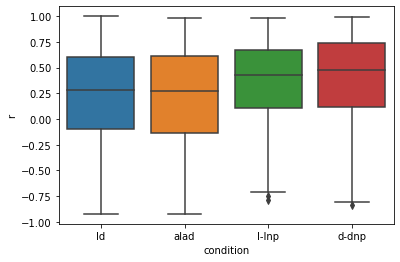

In [16]:
import seaborn as sns
sns.boxplot(x="condition", y="r", data=mapCorDf)

In [17]:
fn=myProject.dataPath+"/results/leverHistoCor.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(mapCorDf, handle)

saving: /adata/projects/autopi_ca1/results/leverHistoCor.pickle


### Map correlation light-dark, l1l2 and d1d2, press/noPress

In [18]:
fn=myProject.dataPath+"/results/myLeverMaps.pickle"
with open(fn, 'rb') as handle:
    leverMaps = pickle.load(handle)

In [21]:
print(leverMaps.keys())
print(leverMaps["map"]["light"].keys())
print(leverMaps["map"]["light"]["lever"].shape)

dict_keys(['map', 'angular'])
dict_keys(['lever', 'bridge', 'none'])
(1268, 30, 30)


In [22]:
rotTypes = ["lever","bridge","none"]
env1 = ['light','all_light','all_light_1','all_dark_1',"all_light","all_dark"]
env2 = ['dark','all_dark','all_light_2', 'all_dark_2', "all_light_noPress","all_dark_noPress"]
condNames = ["ld","alad","l1l2","d1d2","l-lnp","d-dnp"]
list(zip(env1,env2,condNames))

[('light', 'dark', 'ld'),
 ('all_light', 'all_dark', 'alad'),
 ('all_light_1', 'all_light_2', 'l1l2'),
 ('all_dark_1', 'all_dark_2', 'd1d2'),
 ('all_light', 'all_light_noPress', 'l-lnp'),
 ('all_dark', 'all_dark_noPress', 'd-dnp')]

In [23]:
mapCorDf = pd.DataFrame()
nCells=leverMaps["map"]["light"]["none"].shape[0]

In [25]:
for r in rotTypes:
    for e1,e2,c in zip(env1,env2,condNames):
        print(e1,e2,c)
        correlation  = [ map_cor(leverMaps["map"][e1][r][i],leverMaps["map"][e2][r][i]) for i in range(nCells) ]
        df1 = pd.DataFrame({"rotation":r,
                            "condition":c,
                           "r":correlation})
        mapCorDf = pd.concat([mapCorDf,df1])

light dark ld
all_light all_dark alad
all_light_1 all_light_2 l1l2
all_dark_1 all_dark_2 d1d2


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


all_light all_light_noPress l-lnp
all_dark all_dark_noPress d-dnp
light dark ld
all_light all_dark alad
all_light_1 all_light_2 l1l2
all_dark_1 all_dark_2 d1d2
all_light all_light_noPress l-lnp
all_dark all_dark_noPress d-dnp
light dark ld
all_light all_dark alad
all_light_1 all_light_2 l1l2
all_dark_1 all_dark_2 d1d2
all_light all_light_noPress l-lnp
all_dark all_dark_noPress d-dnp


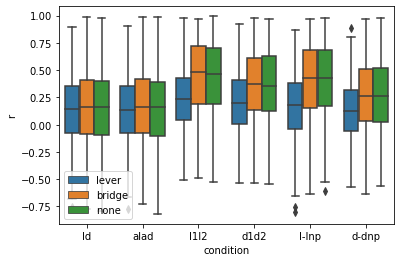

In [26]:
import seaborn as sns
sns.boxplot(x="condition", y="r", hue = "rotation", data=mapCorDf)
plt.legend(loc="lower left")

In [27]:
fn=myProject.dataPath+"/results/leverMapCor.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(mapCorDf, handle)

saving: /adata/projects/autopi_ca1/results/leverMapCor.pickle


## Map correlations between quadrant maps, north-south-east-west

In [28]:
fn=myProject.dataPath+"/results/myLeverQuadMaps.pickle"
with open(fn, 'rb') as handle:
    leverQuadMaps = pickle.load(handle)

In [29]:
print(leverQuadMaps.keys())
print(leverQuadMaps["dark"].keys())

dict_keys(['light', 'dark', 'all_light', 'all_dark'])
dict_keys(['sw', 'nw', 'ne', 'se'])


In [30]:
env1 = ['sw','nw','sw','nw','se','sw']
env2 = ['ne','se','se','ne','ne','nw']
condNames = ["sw-ne","nw-se","sw-se","nw-ne","se-ne",'sw-nw']
list(zip(env1,env2,condNames))

[('sw', 'ne', 'sw-ne'),
 ('nw', 'se', 'nw-se'),
 ('sw', 'se', 'sw-se'),
 ('nw', 'ne', 'nw-ne'),
 ('se', 'ne', 'se-ne'),
 ('sw', 'nw', 'sw-nw')]

We create a data frame with light condition and condNames

In [31]:
mapCorDf = pd.DataFrame()
nCells=leverQuadMaps["light"]["sw"].shape[0]
for cond in leverQuadMaps.keys():
    
    for e1,e2,c in zip(env1,env2,condNames):
        print(cond,e1,e2,c)
        correlation  = [map_cor(leverQuadMaps[cond][e1][i],leverQuadMaps[cond][e2][i]) for i in range(nCells) ]
        df1 = pd.DataFrame({"condition":cond,
                            "key":c,
                           "r":correlation})
        mapCorDf = pd.concat([mapCorDf,df1])

light sw ne sw-ne
light nw se nw-se
light sw se sw-se
light nw ne nw-ne


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


light se ne se-ne
light sw nw sw-nw
dark sw ne sw-ne
dark nw se nw-se
dark sw se sw-se
dark nw ne nw-ne
dark se ne se-ne
dark sw nw sw-nw
all_light sw ne sw-ne
all_light nw se nw-se
all_light sw se sw-se
all_light nw ne nw-ne
all_light se ne se-ne
all_light sw nw sw-nw
all_dark sw ne sw-ne
all_dark nw se nw-se
all_dark sw se sw-se
all_dark nw ne nw-ne
all_dark se ne se-ne
all_dark sw nw sw-nw


In [32]:
mapCorDf

,condition,key,r
0,light,sw-ne,0.550092
1,light,sw-ne,0.070397
2,light,sw-ne,-0.072791
3,light,sw-ne,0.347156
4,light,sw-ne,0.111417
...,...,...,...
1263,all_dark,sw-nw,0.524997
1264,all_dark,sw-nw,0.475607
1265,all_dark,sw-nw,0.243397
1266,all_dark,sw-nw,0.406808


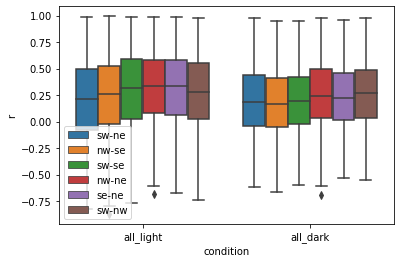

In [33]:
select = ["all_light","all_dark"]
df = mapCorDf[mapCorDf.condition.isin(select)]
sns.boxplot(x="condition", y="r", hue="key", data=df)
plt.legend(loc='lower left')

In [34]:
fn=myProject.dataPath+"/results/leverQuadMapCor.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(mapCorDf, handle)

saving: /adata/projects/autopi_ca1/results/leverQuadMapCor.pickle


## Correlation between quadrants after applying a rotation on the maps

The fields around the lever are relatively stable across quadrant. But it is possible the homing direction influences the exact location of the field.

Hypothesis:
* When the lever is located W, the fields are slightly rotated counterclockwise relative to when the lever is centered
* When the lever is located E, the fields are slightly rotated clockwise relative to when the lever is centered

We can test this by performing map correlation between NW and NE maps and SW and SE maps. The largest shift should be with S compare to N.


Procedure

1. Invalidate bins that are more than 20 cm from the lever. 
2. Perform a series of correlations between W and E maps after different rotation of the E map. Save the r as a function of rotation.


In [35]:
fn=myProject.dataPath+"/results/myLeverQuadMaps.pickle"
with open(fn, 'rb') as handle:
    leverQuadMaps = pickle.load(handle)

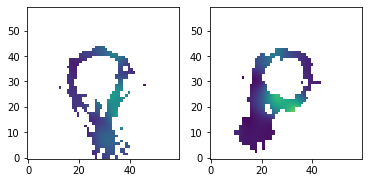

In [36]:
mapSW = leverQuadMaps["all_light"]["sw"][-1].copy()
mapSE = leverQuadMaps["all_light"]["se"][-1].copy()

fig,axes = plt.subplots(1,2)
axes[0].imshow(mapSW.T, origin="lower")
axes[1].imshow(mapSE.T, origin="lower")

(60, 60)


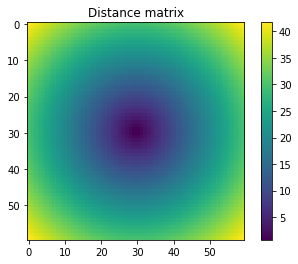

In [37]:
# get the distance from center in the maps
cmPerBin=1
points = np.arange(-mapSW.shape[0]/2+cmPerBin/2,mapSW.shape[0]/2,1)
xs,ys = np.meshgrid(points,points)
distanceMatrix = np.sqrt(xs**2 + ys**2)
plt.imshow(distanceMatrix)
plt.colorbar()
plt.title("Distance matrix")
print(distanceMatrix.shape)

In [38]:
# set to np.nan values bins with a large distance
for k in leverQuadMaps.keys():
    for kk in leverQuadMaps[k].keys():
        leverQuadMaps[k][kk][:,distanceMatrix>17] = np.nan   

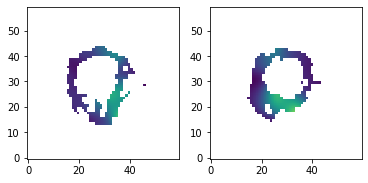

In [39]:
mapSW = leverQuadMaps["all_light"]["sw"][-1].copy()
mapSE = leverQuadMaps["all_light"]["se"][-1].copy()
fig,axes = plt.subplots(1,2)
axes[0].imshow(mapSW.T, origin="lower")
axes[1].imshow(mapSE.T, origin="lower")

## Rotations

I could not use the scipy.ndimage.rotate() because of the np.nan values.

1. Get a 2D vector for each pixel representing its position relative the the map center
2. Use a 2D rotation matrix to rotate the vectors
3. Use the rotated vectors to get indices of the new bins in the rotated map.
3. Move pixels to the new bins



In [40]:
from scipy.stats import pearsonr
def map_cor(a,b,minValidPairs=10):
    """
    Correlation coefficient between two firing rate maps
    
    Arguments:
    a: 2D np.array (map1)
    b: 2D np.array (map2)
    
    Returns:
    Pearson correlation coefficient between a and b
    """
    a = a.flatten()
    b = b.flatten()
    indices = np.logical_and(~np.isnan(a), ~np.isnan(b))
    if np.sum(indices) < minValidPairs :
        return np.nan
    else:
        r,p = pearsonr(a[indices],b[indices])
        return r
    

In [41]:
def rotate_2D_matrix(m, rotation):
    """
    Rotate the values in a square matrix around their center.
    
    I haven't try this with rectangular matrices
    The code could be faster if we made a class out of this and calculated the generic part only once, but coding time is a valuable comodity.
    
    Arguments:
    
    m: a 2D matrix
    rotation: rotation in radians
    
    Return
    A 2D matrix with the value rotated
    """

    #############################################
    # generic, could be calculated only once
    # if we know map size and required rotations 
    #############################################
    
    points = np.arange(-m.shape[0]/2,m.shape[1]/2,1)
    xs,ys = np.meshgrid(points,points)
    
    # original vector for each pixel in the map
    oriVectors = np.vstack([xs.flatten(),ys.flatten()]).T # x by 2 matrix, one vector per row
   
    
    # this is a rotation matrix for our vectors
    rotMat = np.array([[np.cos(rotation), -np.sin(rotation)],
                       [np.sin(rotation), np.cos(rotation)]])
    
    # rotate the vectors, matrix multiplication!
    rotVectors = oriVectors@rotMat
    
    # identify vectors that will be outside of original image
    outside = np.logical_or(rotVectors< -m.shape[0]/2,rotVectors > m.shape[0]/2-1)
    rotVectors[outside] = np.nan  # some part of the image will be outside the border, set to 
    rotVectors = np.rint(rotVectors) # round to nearest integer
    
    keep = ~np.isnan(rotVectors).any(axis=1) # any value is nan for a vector, we don't want to deal with it.
    
    #################################################
    # not generic, needs to be applied to every map # 
    #################################################
    
    oriRate = m.flatten() # a 1D vector with the rate, corresponding to each vector in oriVectors
    # keep only vector for which we can work with
    oriRate = oriRate[keep]
    rotVectors = rotVectors[keep,:]
    
    # tranform vectors to to indices (closest integers, coordinate 0,0 is not the center anymore)
    rotVectors = rotVectors+mapSW.shape[0]/2
    rotVectors = rotVectors.astype(int)
    
    # copy the rates back into the new map.
    mapRot = np.empty_like(m)
    mapRot[:]=np.nan
    mapRot[rotVectors[:,1],rotVectors[:,0]] = oriRate
    
    return mapRot

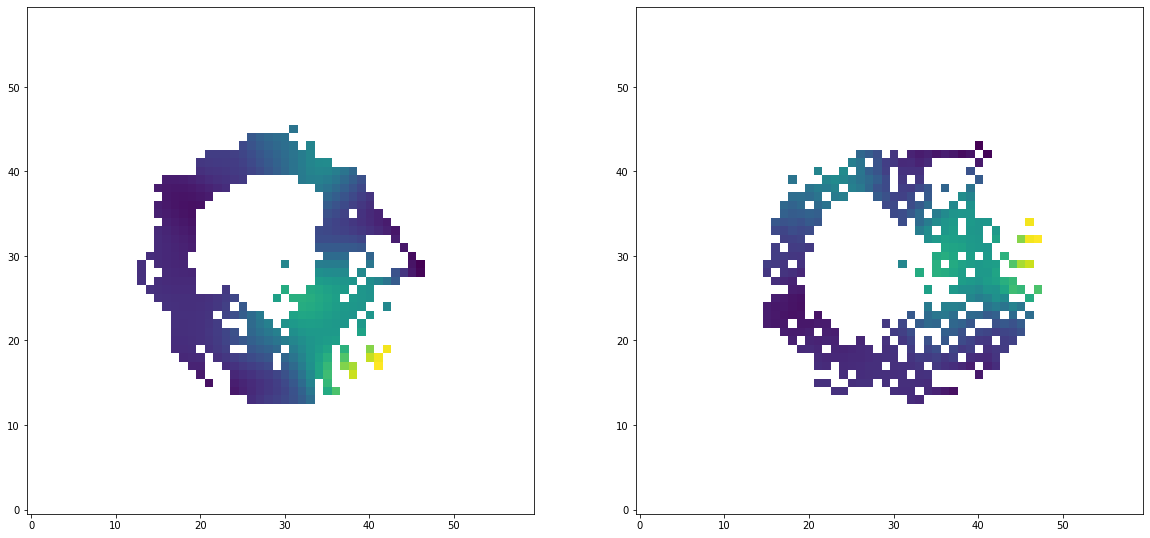

In [42]:
mapSW_rot = rotate_2D_matrix(mapSW, np.pi/3.2)

fig,axes = plt.subplots(1,2,figsize=(20,20))
axes[0].imshow(mapSW.T, origin="lower")
axes[1].imshow(mapSW_rot.T, origin="lower")

Apply to all our maps

In [43]:
%%time
rotations=np.arange(-np.pi,np.pi+np.pi/36,np.pi/36)
myDict = {}

for k in leverQuadMaps.keys():
    myDict[k] ={}
    for c1,c2 in zip(["sw","nw"],["se","ne"]):
        print(k,c1,c2)
        cName="{}_{}".format(c1,c2)
        myDict[k][cName]=np.empty([leverQuadMaps[k][c1].shape[0], rotations.shape[0]])
        for i in range(leverQuadMaps[k][c1].shape[0]):
            for j,rotation in enumerate(rotations):
                mapOne = leverQuadMaps[k][c1][i]
                mapRot = rotate_2D_matrix(leverQuadMaps[k][c2][i],rotation)
                myDict[k][cName][i,j] = map_cor(mapOne,mapRot)
        

light sw se


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


light nw ne
dark sw se
dark nw ne
all_light sw se
all_light nw ne
all_dark sw se
all_dark nw ne
CPU times: user 3min 22s, sys: 0 ns, total: 3min 22s
Wall time: 3min 22s


In [48]:
myDict.keys(),myDict["all_light"].keys()

(dict_keys(['light', 'dark', 'all_light', 'all_dark']),
 dict_keys(['sw_se', 'nw_ne']))

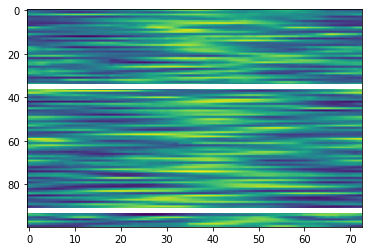

In [49]:
plt.imshow(myDict["all_light"]["sw_se"][0:100,:],aspect="auto")

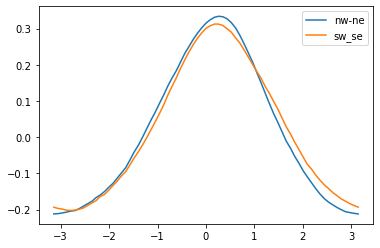

In [50]:
plt.plot(rotations,np.nanmean(myDict["all_light"]["nw_ne"],axis=0),label="nw-ne")
plt.plot(rotations,np.nanmean(myDict["all_light"]["sw_se"],axis=0),label="sw_se")
plt.legend()

In [51]:
fn=myProject.dataPath+"/results/leverQuadMapRotCor.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myDict, handle)

saving: /adata/projects/autopi_ca1/results/leverQuadMapRotCor.pickle


## Get the stats for the lever-centered maps

In [52]:
def getLeverStats(ses,sSes,interName="light",conditionName="light"):
    """
    Get all the maps of the data within the intervals of interest
    """
   
    # change the x and y position of the mouse so that it is relative to the lever position
    
    sSes.ap.load_pose_from_file() # get original hd data
    
    
    # calculate lever position
    fn = sSes.path+"/leverPose"
    leverPose = pd.read_csv(fn)
    leverX = (leverPose.leverPressX + leverPose.leverBoxPLX + leverPose.leverBoxPRX)/3
    leverY = (leverPose.leverPressY + leverPose.leverBoxPLY + leverPose.leverBoxPRY)/3
    
    # transform the animal position so that it is centered on lever

    mouseX = sSes.ap.pose[:,1]-leverX
    mouseY = sSes.ap.pose[:,2]-leverY
    D = np.sqrt(mouseX**2+mouseY**2)
    maxDist = 30 # maximal distance from lever
    mouseX[D>maxDist]= np.nan
    mouseY[D>maxDist]= np.nan
    
    # replace x and y by mouseX and mouseY in ap.pose_ori[:4]
    sSes.ap.pose_ori[:,1] = mouseX
    sSes.ap.pose_ori[:,2] = mouseY
    
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    # maps no smoothing
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_map_2d(cm_per_bin =1, smoothing_sigma_cm = 3, smoothing=False,xy_range=xy_range)
    
    res={}
    res["cellId"] = [sSes.name+"_"+ n.name for n in sSes.cg.neuron_list]
    res["condition"] = conditionName
    res["info"] = [ n.spatial_properties.information_score() for n in sSes.cg.neuron_list]
    df = pd.DataFrame(res)
    
    return df

In [54]:
sSes = sSesList[-1]
ses = myProject.sessionList[-1]
df = getLeverStats(ses,sSes,interName="dark",conditionName="dark")
df

NameError: name 'xy_range' is not defined

In [104]:
conditions = ["light","dark"]
conditionNames = ["light","dark"]

In [107]:
dfLeverStats = pd.DataFrame()
for cond, conditionName in zip(conditions,conditionNames):
    print(cond)
    condDfLeverStats = pd.concat([getLeverStats(ses,sSes,cond,conditionName) for ses,sSes in zip(myProject.sessionList,sSesList)])               
    dfLeverStats = pd.concat([dfLeverStats,condDfLeverStats])

light
dark


In [108]:
dfLeverStats.shape

(2978, 3)

In [109]:
fn=fn=myProject.dataPath+"/results/myLeverStats.csv"
print("Saving",fn)
dfLeverStats.to_csv(fn,index=False)

/adata/projects/autopi_ca1/results/myLeverStats.csv


## Calculate the threshold for information score from the shuffle

In [124]:
def getLeverStatsThreshold(ses,sSes,interName="light",conditionName="light"):
    """
    Get all the maps of the data within the intervals of interest
    """
   
    # change the x and y position of the mouse so that it is relative to the lever position
    
    sSes.ap.load_pose_from_file() # get original hd data
    
    
    # calculate lever position
    fn = sSes.path+"/leverPose"
    leverPose = pd.read_csv(fn)
    leverX = (leverPose.leverPressX + leverPose.leverBoxPLX + leverPose.leverBoxPRX)/3
    leverY = (leverPose.leverPressY + leverPose.leverBoxPLY + leverPose.leverBoxPRY)/3
    
    # transform the animal position so that it is centered on lever

    mouseX = sSes.ap.pose[:,1]-leverX
    mouseY = sSes.ap.pose[:,2]-leverY
    D = np.sqrt(mouseX**2+mouseY**2)
    maxDist = 30 # maximal distance from lever
    mouseX[D>maxDist]= np.nan
    mouseY[D>maxDist]= np.nan
    
    # replace x and y by mouseX and mouseY in ap.pose_ori[:4]
    sSes.ap.pose_ori[:,1] = mouseX
    sSes.ap.pose_ori[:,2] = mouseY
    
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    # maps no smoothing
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.shuffle_info_score(iterations=100,cm_per_bin=1,percentile=95)
        
    
    res={}
    res["cellId"] = [sSes.name+"_"+ n.name for n in sSes.cg.neuron_list]
    res["condition"] = conditionName
    res["infoThreshold"] = [ n.spatial_properties.spatial_info_score_threshold for n in sSes.cg.neuron_list]
    df = pd.DataFrame(res)
    
    return df

In [125]:
#[ (i,ses.name) for i,ses in enumerate(sSesList)]
sSes = sSesList[43]
ses = myProject.sessionList[43]
res = getLeverStatsThreshold(ses,sSes,interName="dark",conditionName="dark")
res1 = getLeverStats(ses,sSes,cond,conditionName) 
print(sSes.name,sSes.path)

mn9686-01112021-0106 /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106


In [ ]:
conditions = ["light","dark"]
conditionNames = ["light","dark"]

In [128]:
dfLeverStatsThre = pd.DataFrame()
for cond, conditionName in zip(conditions,conditionNames):
    print(cond)
    condDfLeverStats = pd.concat([getLeverStatsThreshold(ses,sSes,cond,conditionName) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))])               
    dfLeverStatsThre = pd.concat([dfLeverStatsThre,condDfLeverStats])

light


44it [17:23, 23.72s/it]


dark


44it [25:07, 34.26s/it]


In [129]:
dfLeverStatsThre.shape

(2978, 3)

In [130]:
fn=myProject.dataPath+"/results/myLeverStatsThreshold.csv"
print("Saving",fn)
dfLeverStatsThre.to_csv(fn,index=False)

Saving /adata/projects/autopi_ca1/results/myLeverStatsThreshold.csv


## Get the position of the lever for each trial 

To show that the lever changed position during a session, we can make scatter plot of the lever position

In [77]:
ses = myProject.sessionList[0]
sSes = sSesList[0]
ses.trials

,sessionName,trialNo,startTime,endTime,startTimeWS,endTimeWS,light,recStartTime,recEndTime
0,mn5824-20112020-0107,3,1.605898e+09,1.605898e+09,79.781043,88.438520,light,3101.447869,3110.099916
1,mn5824-20112020-0107,4,1.605898e+09,1.605898e+09,96.439776,135.060449,light,3118.107390,3156.725956
2,mn5824-20112020-0107,5,1.605898e+09,1.605898e+09,162.047405,170.261472,light,3183.718996,3191.917945
3,mn5824-20112020-0107,6,1.605898e+09,1.605898e+09,185.268787,202.939007,light,3206.936797,3224.609053
4,mn5824-20112020-0107,7,1.605898e+09,1.605898e+09,215.946754,225.353069,light,3237.608974,3247.024326
...,...,...,...,...,...,...,...,...,...
145,mn5824-20112020-0107,148,1.605903e+09,1.605904e+09,5769.214389,5800.822207,dark,8638.626393,8670.229337
146,mn5824-20112020-0107,149,1.605904e+09,1.605904e+09,5838.682771,5850.946387,light,8708.091852,8720.360005
147,mn5824-20112020-0107,150,1.605904e+09,1.605904e+09,5870.966416,5904.769234,dark,8740.376523,8774.177785
148,mn5824-20112020-0107,151,1.605904e+09,1.605904e+09,5912.797614,5942.171127,light,8782.214397,8811.576378


In [78]:
def leverTrialPosition(ses):
    """
    Returns a DataFrame with the lever position
    
    """
    # calculate lever position
    fn = sSes.path+"/leverPose"
    leverPose = pd.read_csv(fn)
    leverPoseTrial=np.empty((len(ses.trials),4))

    for i in range(len(ses.trials)):
        start = ses.trials.recStartTime[i]
        end = ses.trials.recEndTime[i] 
        indices = np.logical_and(leverPose.timeRec>start,leverPose.timeRec<end)
        lp = leverPose[indices]
        leverPoseTrial[i,2]=i
        leverPoseTrial[i,0] = (np.nanmedian(lp.leverPressX)+np.nanmedian(lp.leverBoxPLX)+np.nanmedian(lp.leverBoxPRX))/3
        leverPoseTrial[i,1]= (np.nanmedian(lp.leverPressY)+np.nanmedian(lp.leverBoxPLY)+np.nanmedian(lp.leverBoxPRY))/3

    df = pd.DataFrame({"session": ses.name,
                     "trial":leverPoseTrial[:,2],
                     "x":leverPoseTrial[:,0],
                     "y":leverPoseTrial[:,1],
                      "light":ses.trials.light})    
    return df

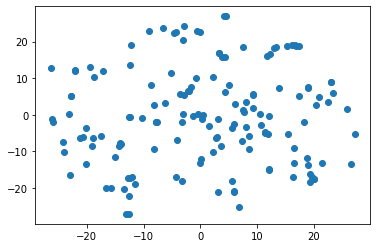

In [83]:
df = leverTrialPosition(ses)
plt.scatter(df.x,df.y)
plt.show()

In [80]:
dfLev = pd.concat([leverTrialPosition(ses) for ses in myProject.sessionList])

/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


(5299, 5)

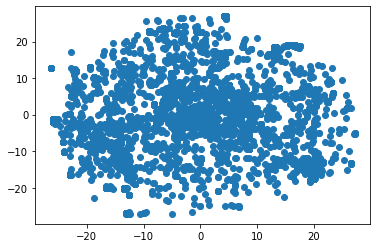

In [84]:
plt.scatter(dfLev.x,dfLev.y)
dfLev.shape

In [85]:
fn=fn=myProject.dataPath+"/results/dfLev.csv"
print(fn)
dfLev.to_csv(fn,index=False)

/adata/projects/autopi_ca1/results/dfLev.csv
